In [19]:
pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd 
import numpy as np
import lightgbm as lgbm
import sklearn as sk
import xgboost as xgb
from sklearn import model_selection
from sklearn import ensemble
from sklearn import preprocessing as sk_prep
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, plot_confusion_matrix, plot_roc_curve
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns

In [34]:
#cargar datos de nuestra carpeta de datos local
base_path = r"D:\LIBRERIAS\Downloads\ETD_NTT_DATA_FOUNDATION\RETOS\RETO 3\df_estados_bank.csv"

# eliminar variables que no serán útiles (como el apellido del cliente), son identificadores del cliente o
# información personal sin ninguna relación con su probabilidad de abandono
df_base = pd.read_csv(base_path, sep=',').drop(columns=['Unnamed: 0', 'RowNumber', 'Surname', 'CustomerId'], axis = 1)

HTML(df_base.head(20).to_html(index = False))

CreditScore,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,Age,Geography,EstimatedSalary,Exited,Tenure
619,Female,0.00,1,1,1,42.0,Texas,101348.88,1,2
608,Female,83807.86,1,0,1,41.0,California,112542.58,0,1
502,Female,159660.80,3,1,0,42.0,Texas,113931.57,1,8
699,Female,0.00,2,0,0,39.0,Texas,93826.63,0,1
850,Female,125510.82,1,1,1,43.0,California,79084.10,0,2
645,Male,113755.78,2,1,0,44.0,California,149756.71,0,8
822,Male,0.00,2,1,1,50.0,Texas,10062.80,0,7
376,Female,115046.74,4,1,0,29.0,Alabama,119346.88,1,4
501,Male,142051.07,2,0,1,NaN,Texas,74940.50,0,4
684,Male,134603.88,1,1,1,NaN,Texas,71725.73,0,2


In [35]:
# Tenemos varios atributos como la edad de los clientes, la antiguedad, el número de productos, etc. 
# Todos potencialmente interesantes para analizar y predecir el abandono de los clientes. 
# ¿Cuántos datos tenemos?
print(df_base.shape)

(10000, 11)


In [36]:
# crear metadatos
label = 'Exited'
df_columns = list(df_base.columns)
df_columns.remove(label)
print(df_columns)

['CreditScore', 'Gender', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age', 'Geography', 'EstimatedSalary', 'Tenure']


['CreditScore', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Age', 'EstimatedSalary', 'Tenure']


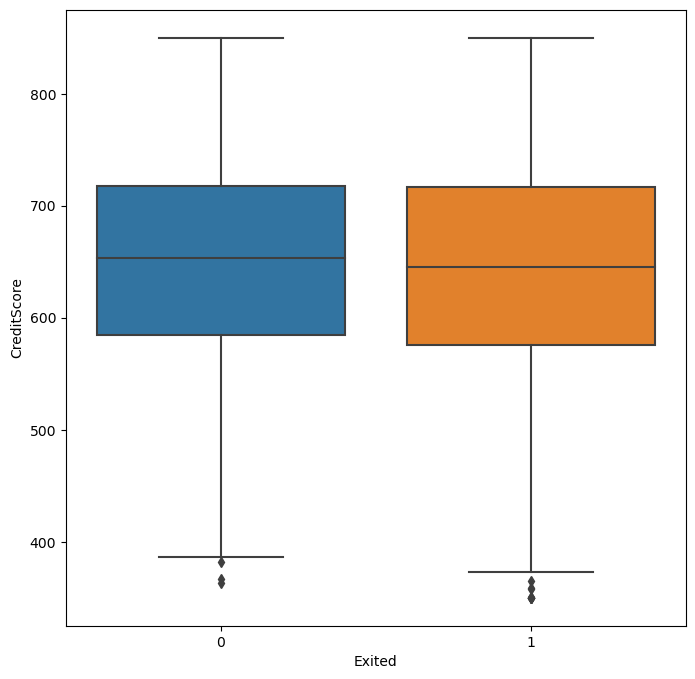

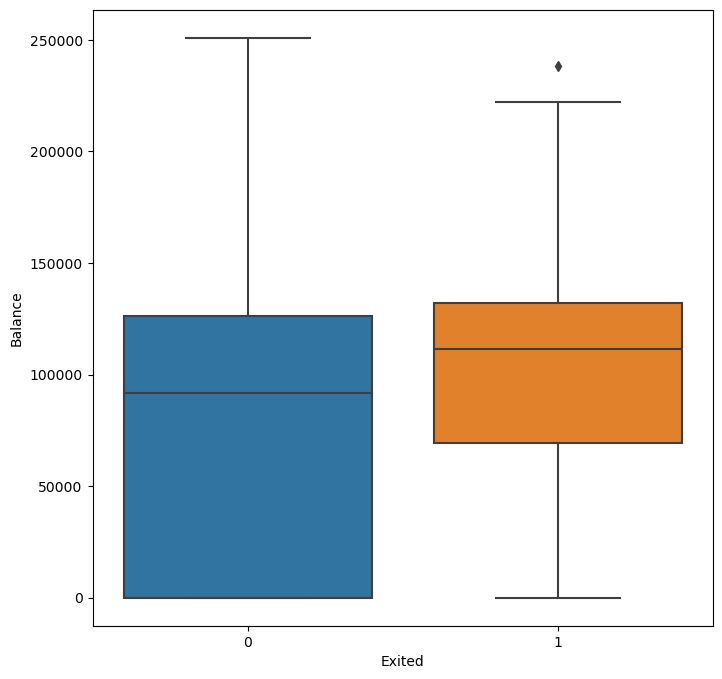

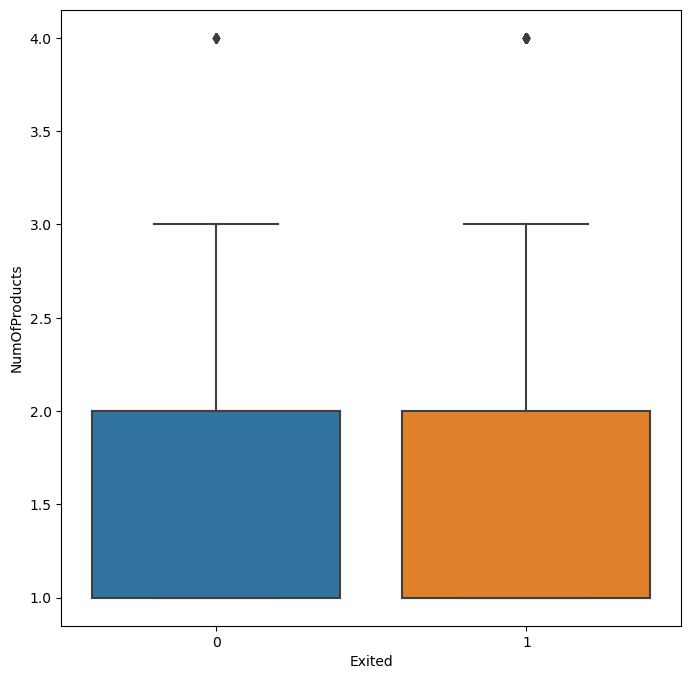

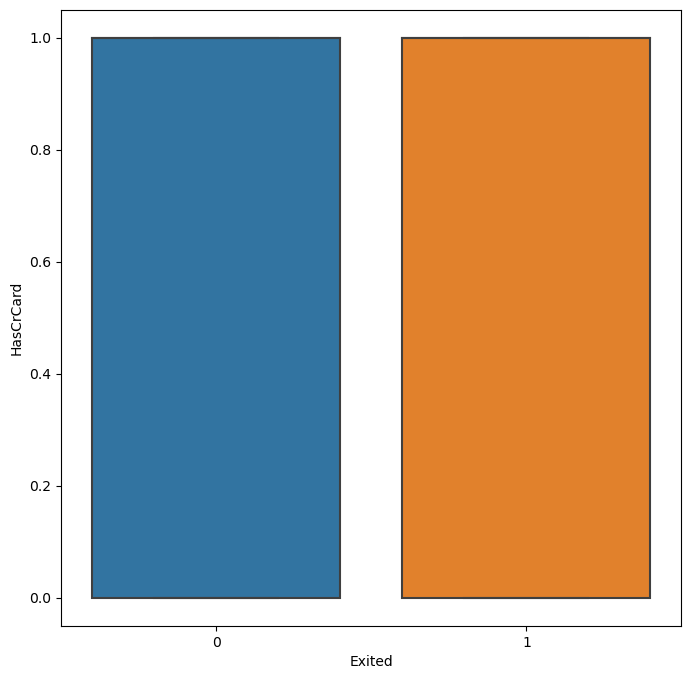

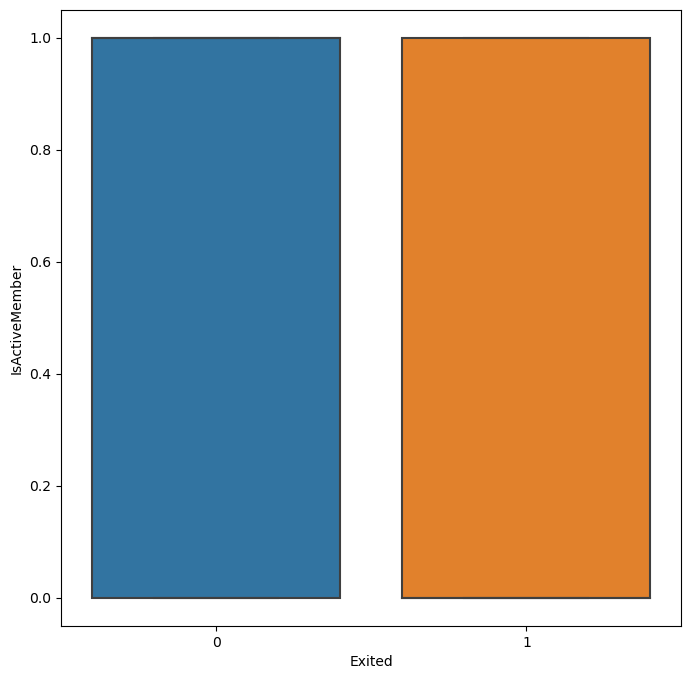

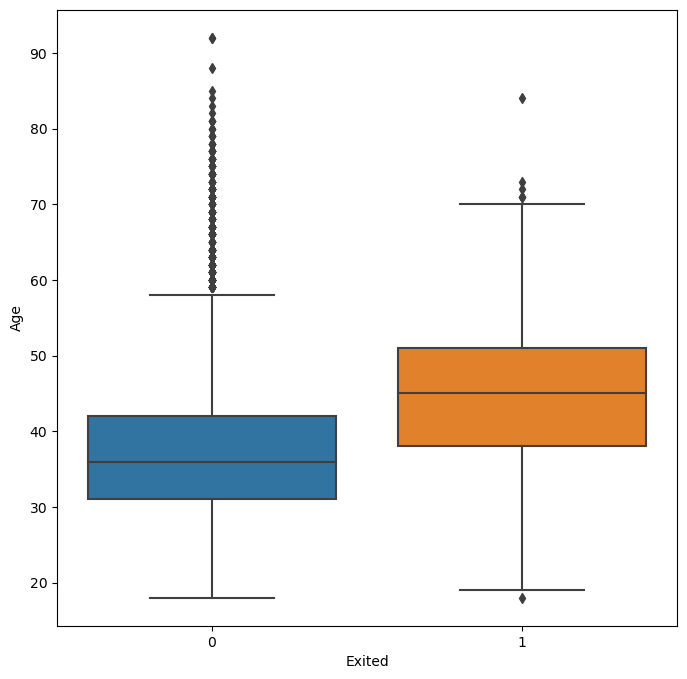

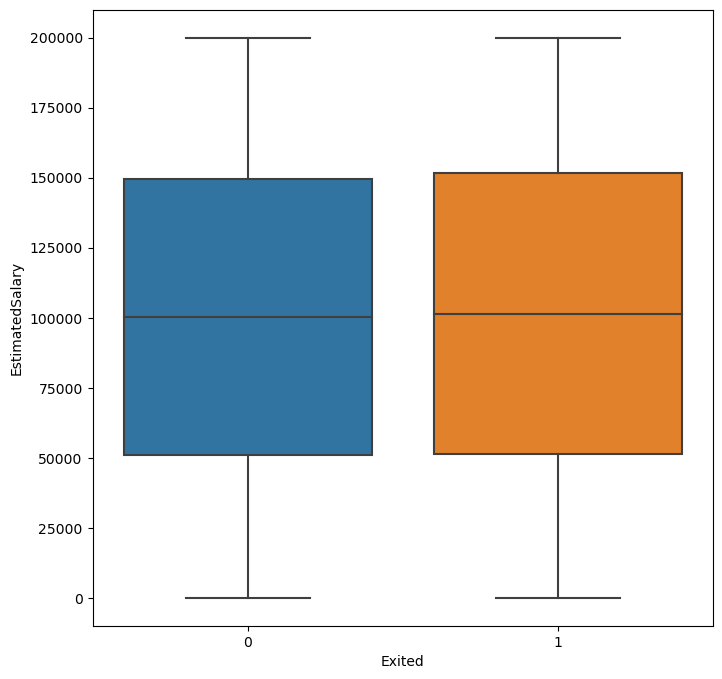

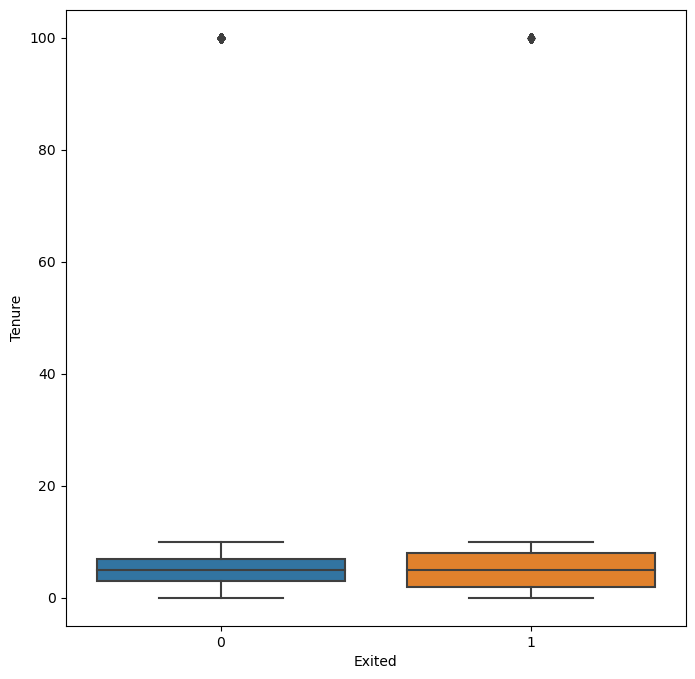

In [37]:
# alguna EDA 
# Vamos a explorar visualmente los datos con algunos gráficos básicos.
# detectar datos numéricos y categóricos
num_cols = list(df_base._get_numeric_data().columns)
num_cols.remove(label)
# use nuestras columnas numéricas para averiguar nuestras columnas categóricas
cat_cols = list(set(df_base.columns) - set(num_cols))

print(num_cols)

# para columnas numéricas, plot bloxplots matizados por el target,
for c in num_cols:
    plt.figure(figsize=(8,8)) 
    ax = sns.boxplot(x=label, y=c,  data=df_base)
    
    
# Una de las columnas que puede ser importante en el análisis puede ser Edad. 
# Vemos que al segmentarla por el label, diferencia los casos 0 (no abandona) y 1 (abandona) de manera significativa.

['Exited', 'Gender', 'Geography']


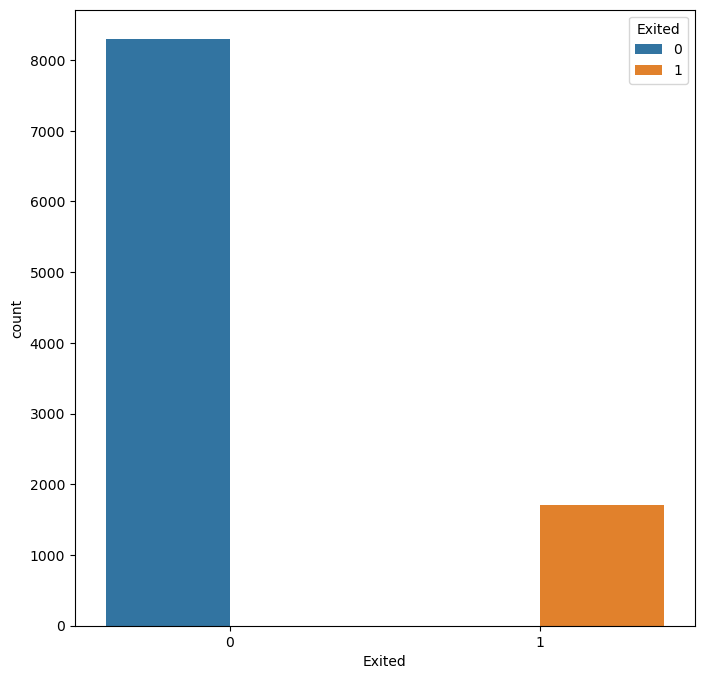

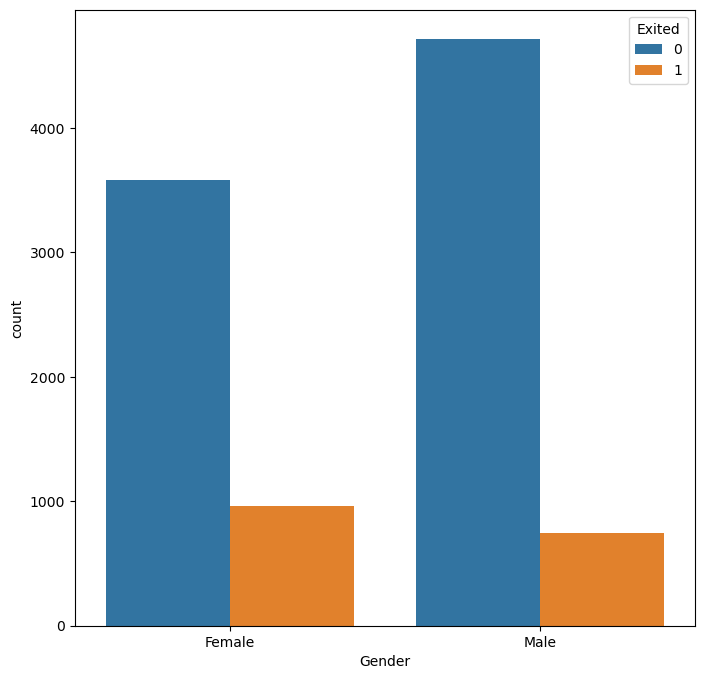

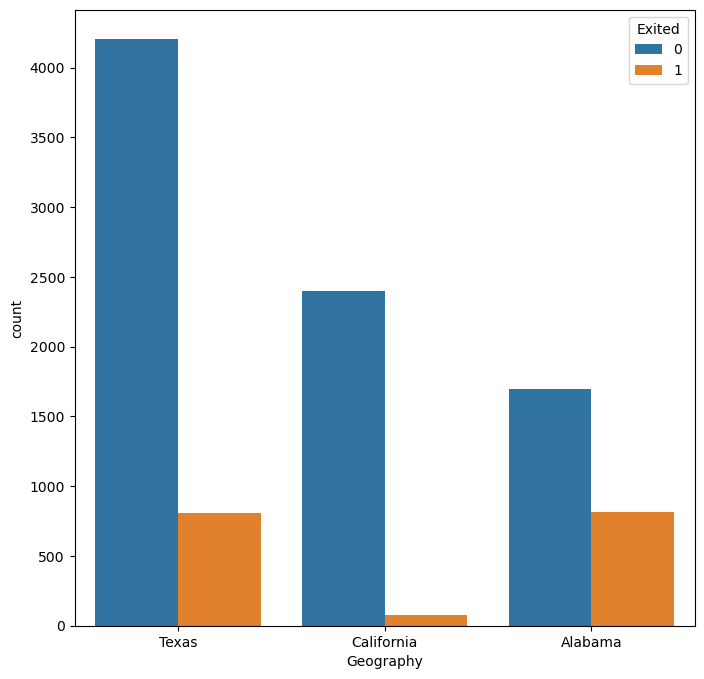

In [38]:
# para datos categóricos crear histogramas
print(cat_cols)

for c in cat_cols:
    plt.figure(figsize=(8, 8))
    ax = sns.countplot(x=c, hue=label, data=df_base)
    
# En principio no parece que estos atributos segmenten bien el hecho de que un cliente nos abandone, 
# pero esperemos al impacto que pueden tener cuando construyamos el modelo.

In [40]:
# Reemplazamos los nulos con la mediana
df_base['Age'].fillna(df_base['Age'].median(), inplace=True)
df_base['EstimatedSalary'].fillna(df_base['EstimatedSalary'].median(), inplace=True)
df_base

,CreditScore,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,Age,Geography,EstimatedSalary,Exited,Tenure
0,619,Female,0.00,1,1,1,42.0,Texas,101348.88,1,2
1,608,Female,83807.86,1,0,1,41.0,California,112542.58,0,1
2,502,Female,159660.80,3,1,0,42.0,Texas,113931.57,1,8
3,699,Female,0.00,2,0,0,39.0,Texas,93826.63,0,1
4,850,Female,125510.82,1,1,1,43.0,California,79084.10,0,2
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Male,0.00,2,1,0,39.0,Texas,96270.64,0,5
9996,516,Male,57369.61,1,1,1,35.0,Texas,101699.77,0,10
9997,709,Female,0.00,1,0,1,37.0,Texas,42085.58,1,7
9998,772,Male,75075.31,2,1,0,42.0,Alabama,92888.52,1,3


In [41]:
# Vamos a usar la codificación más sencilla posible, la que nos ofrece OrdinalEncoder.
# codificadores Solo por el bien de la demostración, otras estrategias de codificación también serían beneficiosas
l_binarizer = sk_prep.LabelBinarizer()
str_encoder = sk_prep.OrdinalEncoder()

# binarizar etiqueta
y_encoded = l_binarizer.fit_transform(y=df_base[label])

# codificar cadenas
X_encoded = pd.DataFrame(str_encoder.fit_transform(X=df_base.drop(columns = [label], axis = 1)),
                            columns = df_columns)

X_encoded.head(10)

# Como vemos, esta codificación sólo nos traduce de texto a números. 
# Esto hace que ahora el modelo pueda entrenar con éstas variables.

,CreditScore,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,Age,Geography,EstimatedSalary,Tenure
0,228.0,0.0,0.0,0.0,1.0,1.0,24.0,2.0,4649.0,2.0
1,217.0,0.0,743.0,0.0,0.0,1.0,23.0,1.0,5177.0,1.0
2,111.0,0.0,5793.0,2.0,1.0,0.0,24.0,2.0,5241.0,8.0
3,308.0,0.0,0.0,1.0,0.0,0.0,21.0,2.0,4312.0,1.0
4,459.0,0.0,3696.0,0.0,1.0,1.0,25.0,1.0,3610.0,2.0
5,254.0,1.0,2674.0,1.0,1.0,0.0,26.0,1.0,6921.0,8.0
6,431.0,1.0,0.0,1.0,1.0,1.0,32.0,2.0,466.0,7.0
7,8.0,0.0,2781.0,3.0,1.0,0.0,11.0,0.0,5489.0,4.0
8,110.0,1.0,4962.0,1.0,0.0,1.0,19.0,2.0,3421.0,4.0
9,293.0,1.0,4450.0,0.0,1.0,1.0,19.0,2.0,3267.0,2.0


In [42]:
# dividir datos en proporciones de 70-30
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded, y_encoded, test_size = 0.3)

print(X_train.shape, X_test.shape)

(7000, 10) (3000, 10)


In [43]:
# Vamos a usar un bosque de decisión 
# (la combinación de muchos árboles de decisión individuales) 
# por ser un modelo potente y robusto, rápido de entrenar y con una fácil interpetación.

# ajuste un bosque aleatorio con 100 árboles de un máximo de 8 niveles

rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())

RandomForestClassifier(criterion='entropy', max_depth=8, n_jobs=-1)

Accuracy:  0.88
Precision:  0.38
Recall:  0.84
F1:  0.52


C:\Users\Policroarte\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


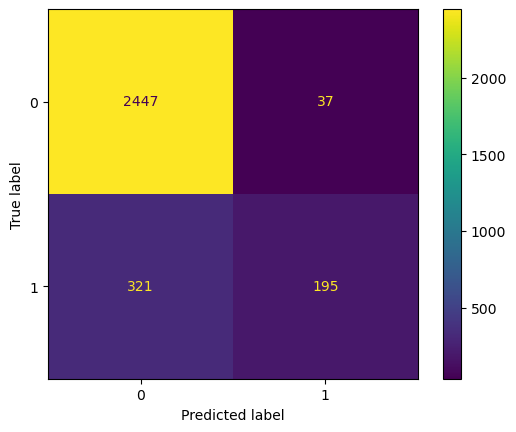

In [44]:
# Una vez entrenado, usaremos el conjunto de test para evaluar el rendimiento de nuestro modelo prediciendo qué clientes abandonarán nuestro negocio y cuáles no.

from sklearn import metrics

# predecir usando nuestro conjunto de prueba e imprimir diferentes medidas de error
preds_proba_rf = rf.predict_proba(X=X_test)
preds_rf = rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
plot_confusion_matrix(estimator=rf, X = X_test, y_true = y_test, values_format='.0f')


# Las métricas son bastante buenas! Un acierto (accuracy) del 88%! Fantástico! 
# O… bueno, pensemos un poco antes. ¿Es realmente el accuracy la métrica que queremos observar?
# ¿Qué quiere detectar nuestro negocio con éste modelo? ...


# Esa es la pregunta que debemos hacernos a la hora de evaluar un modelo. 
# En este caso, la detección de aquellos casos que SÍ abandonan, 
# y dada la codificación de nuestro label (0 -> se queda / 1 -> abandona) 
# queremos ver Precision (abandonos predichos correctamente / (abandonos predichos correctamente + abandonos falsamente predichos)). 
# Tenemos un valor de 38%, no tan buena como parecía en un principio.

C:\Users\Policroarte\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


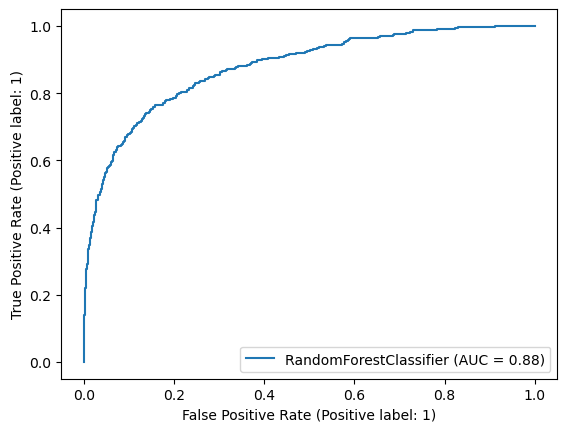

In [45]:
# obtenga la curva roc para verificar si somos mejores que un clasificador aleatorio
plot_roc_curve(estimator=rf, X = X_test, y=y_test)

# Pero si miramos la curva ROC (habitualmente usada en evaluación de modelos de clasificación binaria como éste)
# parece bastante buena…

In [ ]:
# Mejorando el modelo a través de hiperparámetros

# Los hiperámetros son parámetros externos que nosotros especificamos para modificar
# el comportamiento del algoritmo al explorar el dataset y construir reglas
# y ajustar pesos para llegar a las conclusiones que le estemos pidiendo 
# (predecir el abandono de clientes en nuestro caso).

# sintonizar nuestro bosque aleatorio
param_grid = {
    "max_depth": list(range(20, 300, 10)),
    "criterion":  ["gini", "entropy"],
    "max_features":  ["auto", "sqrt"],
    "min_samples_leaf": list(range(1, 5, 1)),
    "min_samples_split": list(range(2, 20, 2)),
    "n_estimators": [int(elems) for elems in list(np.logspace(np.log(100), np.log(800), base = np.exp(1), num = 30))]
}

# use 4 núcleos para cada clasificador y 2 modelos en paralelo
rf = ensemble.RandomForestClassifier(n_jobs = 4)
n_iters = 20

random_search = model_selection.RandomizedSearchCV(estimator = rf, 
                                                   param_distributions = param_grid, 
                                                   n_iter = n_iters, scoring = 'f1', cv = 5, 
                                                   verbose = 1, n_jobs = 2)
# buscar en el espacio aleatorio
random_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=4), n_iter=20,
                   n_jobs=2,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [20, 30, 40, 50, 60, 70,
                                                      80, 90, 100, 110, 120,
                                                      130, 140, 150, 160, 170,
                                                      180, 190, 200, 210, 220,
                                                      230, 240, 250, 260, 270,
                                                      280, 290],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16, 18],
                                        'n_estimators':

Los mejores parámetros observados son:  {'n_estimators': 520, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 260, 'criterion': 'entropy'}
Accuracy:  0.88
Precision:  0.44
Recall:  0.79
F1:  0.57


C:\Users\Policroarte\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


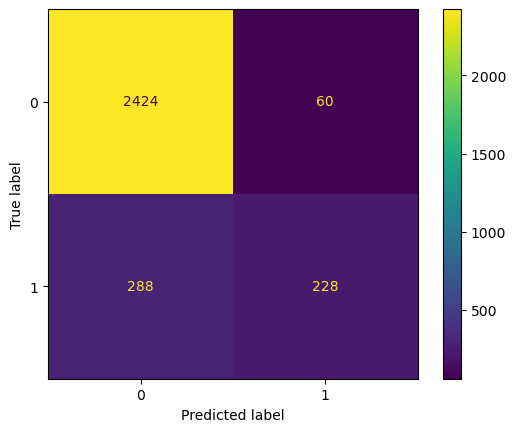

In [47]:
# Vamos a usar F1 Score para elegir la mejor combinación por ser la métrica 
# que refleja el comportamiento de negocio que queremos usar 
# (balance entre los casos de detección de abandono y no-abandono correctamente).

# Vamos a comprobar el rendimiento de nuestro modelo con los nuevos hiperparámetros.

# Consigue nuestro mejor estimador
best_rf = random_search.best_estimator_ 

# mostrar los mejores parámetros
best_params_rf = random_search.best_params_
print('Los mejores parámetros observados son: ', best_params_rf)

# predecir usando nuestro conjunto de prueba e imprimir diferentes medidas de error
from sklearn import metrics

# predecir usando nuestro conjunto de prueba e imprimir diferentes medidas de error
preds_proba_rf = best_rf.predict_proba(X=X_test)
preds_rf = best_rf.predict(X=X_test)

print("Accuracy: ", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision: ", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall: ", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1: ", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
plot_confusion_matrix(estimator=best_rf, X = X_test, y_true = y_test, values_format='.0f')


# Precision ha subido un 6% y F1 Score también lo hace en un 5%… 
# ¡para una exploración sencilla no es mal avance!

In [48]:
# El problema del label desbalanceado

# Ya sabíamos que el abandono de clientes es, por definición, 
# un problema de clasificación binaria desbalanceado, 
# con más casos de un tipo (‘no abandona’) que del otro (‘abandona’).

# cargue nuestra biblioteca de etiquetas desequilibradas
from imblearn.over_sampling import ADASYN, SMOTE, SVMSMOTE

#OVERSAMPLING
sampler_smote = SMOTE(n_jobs = -1)
sampler_svm =  SVMSMOTE(n_jobs = -1)
sampler_adasyn = ADASYN(n_jobs = -1)

X_smote, y_smote = sampler_smote.fit_resample(X = X_train, y=y_train.ravel())
X_svm, y_svm = sampler_svm.fit_resample(X = X_train, y=y_train.ravel())
X_adasyn, y_adasyn = sampler_adasyn.fit_resample(X = X_train, y=y_train.ravel())

print(X_smote.shape, X_svm.shape, X_adasyn.shape)

# Ahora tenemos bastantes más filas en el conjunto de entrenamiento. 
# Ahora tenemos unas 11.600 cuando antes teníamos 7.000,
# resultado de añadir casos “ficticios” pero que se parecen suficiente
#a los que integraban nuestra clase minoritaria (abandona) 
# como para que el algoritmo los use para mejorar su aprendizaje.

C:\Users\Policroarte\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
C:\Users\Policroarte\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\filter.py:461: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


(11626, 10) (11626, 10) (11841, 10)


C:\Users\Policroarte\anaconda3\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [49]:
# Adicionalmente vamos a usar una versión del RandomForestClassifier 
# en el que usaremos subconjuntos de datos balanceados 
# en lo que respecta a la distribución de la clase para cada árbol que construye, sin tocar el dato de entrenamiento original.

#baseline
rf = ensemble.RandomForestClassifier(n_estimators = 100, max_depth=8, criterion="entropy", n_jobs=-1)
rf.fit(X = X_train, y = y_train.ravel())

# A PARTIR DE AHORA UTILICE LA VERSIÓN SINTONIZADA AUNQUE DEBEMOS VOLVER A SINTONIZAR
# clases de peso utilizando el propio modelo
rf_balanced = ensemble.RandomForestClassifier(n_jobs=-1,
                                              class_weight = "balanced_subsample", ##VERY IMPORTANT
                                              **best_params_rf)
rf_balanced.fit(X = X_train, y=y_train.ravel())

# clases de peso + smote
rf_balanced_smote = ensemble.RandomForestClassifier(n_jobs=-1,
                                                    class_weight = "balanced_subsample", ##VERY IMPORTANT
                                                    **best_params_rf) 
rf_balanced_smote.fit(X = X_smote, y=y_smote.ravel())

# default SMOTE
rf_smote = ensemble.RandomForestClassifier(n_jobs=-1,
                                            **best_params_rf)
rf_smote.fit(X = X_smote, y = y_smote.ravel())

# default SVM SMOTE
rf_svm = ensemble.RandomForestClassifier(n_jobs=-1,
                            **best_params_rf)
rf_svm.fit(X = X_svm, y = y_svm.ravel())

# default ADASYN
rf_adasyn = ensemble.RandomForestClassifier(n_jobs=-1,
                            **best_params_rf)
rf_adasyn.fit(X = X_adasyn, y = y_adasyn.ravel())


# Vamos a evaluar nuestros modelos entrenados con diferentes versiones
# de los datasets con supersampleo y con la modificación sobre el bosque 
# de decisión balanceado sobre nuestro dato de test. 
# Es MUY importante que este dato de test no haya sido modificado 
# ni balanceado, y que mantenga la distribución original
# (desbalanceada) que caracteriza a nuestro problema de abandono de clientes.

RandomForestClassifier(criterion='entropy', max_depth=260, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=6,
                       n_estimators=520, n_jobs=-1)

In [50]:
from sklearn import metrics

## MUY IMPORTANTE: TODOS LOS MODELOS HAN SIDO ENTRENADOS CON DIFERENTES CONJUNTOS DE DATOS PERO TODOS SON PROBADOS CONTRA LA MISMA PRUEBA
preds_rf_smote = rf_smote.predict(X=X_test)
preds_rf_svm = rf_svm.predict(X=X_test)
preds_rf_adasyn = rf_adasyn.predict(X=X_test)
preds_rf = rf.predict(X=X_test)
preds_rf_balanced = rf_balanced.predict(X=X_test)
preds_rf_balanced_smote = rf_balanced_smote.predict(X=X_test)

#%%
# IMPRIMIR RESULTADOS
print("Accuracy BASELINE:", round(metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Precision BASELINE:", round(metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("Recall BASELINE:", round(metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))
print("F1 BASELINE:", round(metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel()), 2))

print("Accuracy BALANCED:", round(metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Precision BALANCED:", round(metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Recall BALANCED:", round(metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("F1 BALANCED:", round(metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))

print("Accuracy SMOTE:", round(metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("Precision SMOTE:", round(metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("Recall SMOTE:", round(metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))
print("F1 SMOTE:", round(metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel()), 2))

print("Accuracy SMOTE SVM:", round(metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("Precision SMOTE SVM:", round(metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("Recall SMOTE SVM:", round(metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))
print("F1 SMOTE SVM:", round(metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel()), 2))

print("Accuracy ADASYN:", round(metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("Precision ADASYN:", round(metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("Recall ADASYN:", round(metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))
print("F1 ADASYN:", round(metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel()), 2))

# crear objetos para trazar
precision_baseline = metrics.precision_score(y_true = preds_rf, y_pred = y_test.ravel())
precision_smote = metrics.precision_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
precision_svm = metrics.precision_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
precision_adasyn = metrics.precision_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
precision_balanced = metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
precision_balanced_smote = metrics.precision_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

f1_baseline = metrics.f1_score(y_true = preds_rf, y_pred = y_test.ravel())
f1_smote = metrics.f1_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
f1_svm = metrics.f1_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
f1_adasyn = metrics.f1_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
f1_balanced = metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
f1_balanced_smote = metrics.f1_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

accuracy_baseline = metrics.accuracy_score(y_true = preds_rf, y_pred = y_test.ravel())
accuracy_smote = metrics.accuracy_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
accuracy_svm = metrics.accuracy_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
accuracy_adasyn = metrics.accuracy_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
accuracy_balanced = metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
accuracy_balanced_smote = metrics.accuracy_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

recall_baseline = metrics.recall_score(y_true = preds_rf, y_pred = y_test.ravel())
recall_smote = metrics.recall_score(y_true = preds_rf_smote, y_pred = y_test.ravel())
recall_svm = metrics.recall_score(y_true = preds_rf_svm, y_pred = y_test.ravel())
recall_adasyn = metrics.recall_score(y_true = preds_rf_adasyn, y_pred = y_test.ravel())
recall_balanced = metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel())
recall_balanced_smote = metrics.recall_score(y_true = preds_rf_balanced_smote, y_pred = y_test.ravel())

precision_scores = [precision_baseline, precision_balanced, precision_balanced_smote, precision_smote, precision_svm, precision_adasyn]
f1_scores = [f1_baseline, f1_balanced, f1_balanced_smote, f1_smote, f1_svm, f1_adasyn]
accuracy_scores = [accuracy_baseline, accuracy_balanced, accuracy_balanced_smote, accuracy_smote, accuracy_svm, accuracy_adasyn]
recall_scores = [recall_baseline, recall_balanced, recall_balanced_smote, recall_smote, recall_svm, recall_adasyn]
score_names = ["Baseline", "Balanced", "Balanced_SMOTE", "SMOTE", "SMOTE_SVM", "ADASYN"]

d_prec={'Scores':precision_scores, 'Version': score_names}
precision_scores_df = pd.DataFrame(d_prec)

d_f1={'Scores':f1_scores, 'Version': score_names}
f1_scores_df = pd.DataFrame(d_f1)

d_accuracy = {'Scores':accuracy_scores, 'Version': score_names}
accuracy_scores_df = pd.DataFrame(d_accuracy) 

d_recall = {'Scores':recall_scores, 'Version': score_names}
recall_scores_df = pd.DataFrame(d_recall)

Accuracy BASELINE: 0.88
Precision BASELINE: 0.39
Recall BASELINE: 0.81
F1 BASELINE: 0.53
Accuracy BALANCED: 0.88
Precision BALANCED: 0.55
Recall BALANCED: 0.69
F1 BALANCED: 0.61
Accuracy SMOTE: 0.88
Precision SMOTE: 0.5
Recall SMOTE: 0.7
F1 SMOTE: 0.58
Accuracy SMOTE SVM: 0.88
Precision SMOTE SVM: 0.51
Recall SMOTE SVM: 0.72
F1 SMOTE SVM: 0.6
Accuracy ADASYN: 0.88
Precision ADASYN: 0.51
Recall ADASYN: 0.71
F1 ADASYN: 0.59


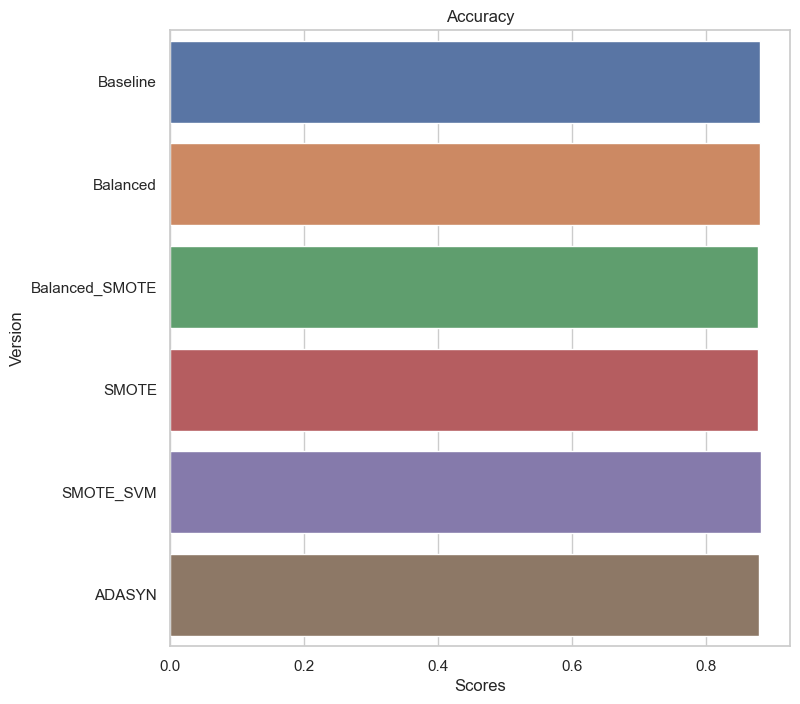

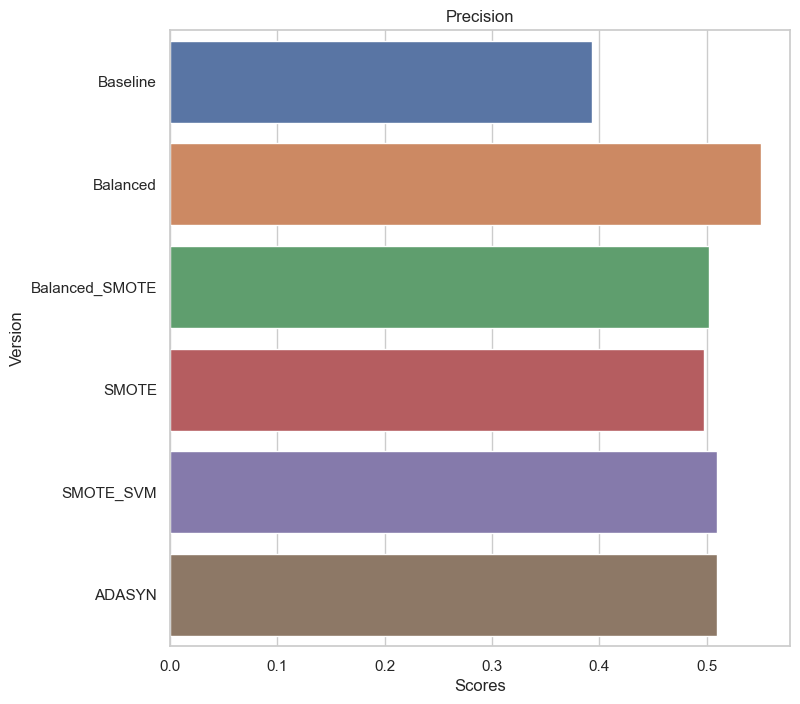

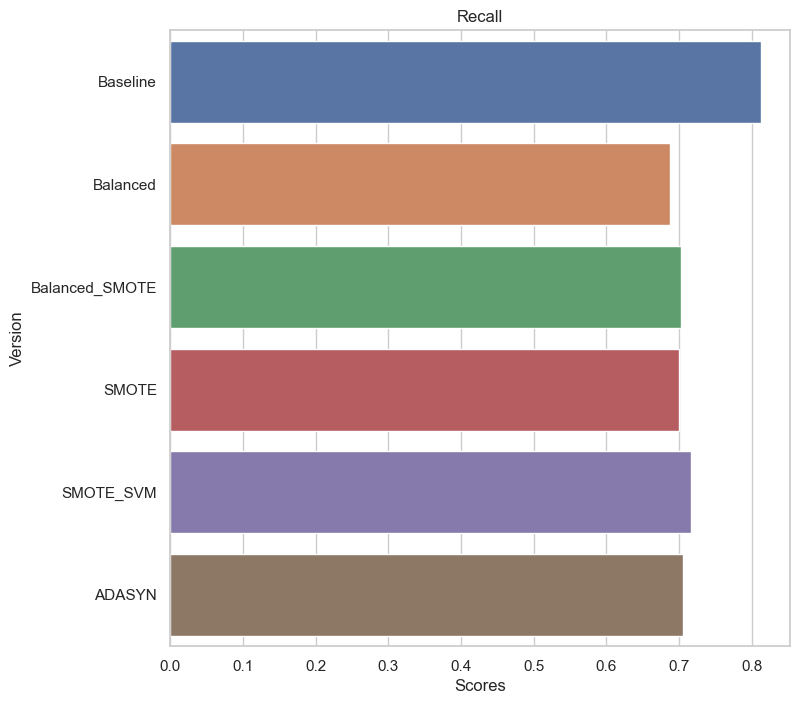

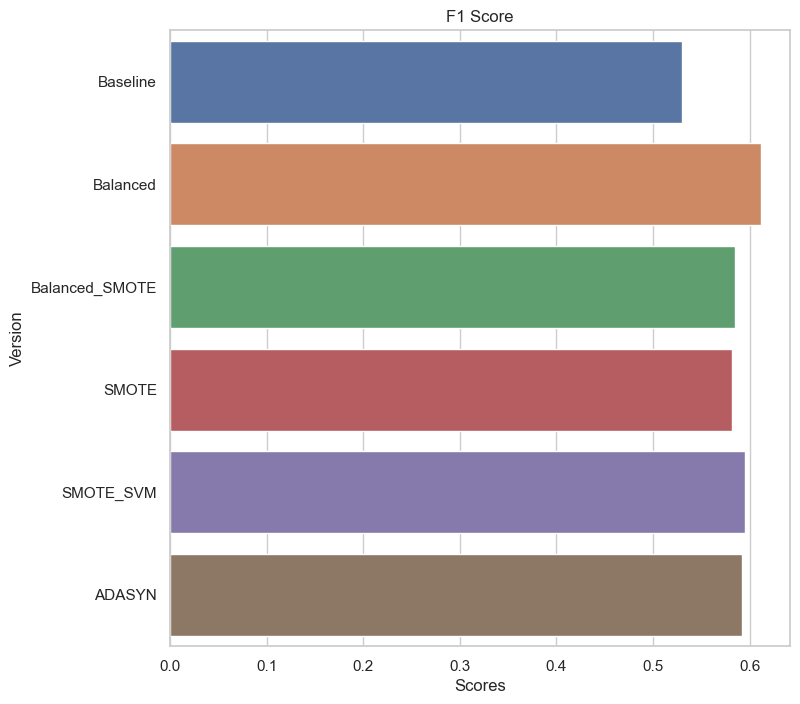

In [51]:
import seaborn as sns

# accuracy plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = accuracy_scores_df).set_title("Accuracy")

#%%
# precision plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = precision_scores_df).set_title("Precision")

#%%
# recall plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = recall_scores_df).set_title("Recall")

#%%
# f1 plot
plt.figure(figsize=(8,8))
sns.set(style="whitegrid")
ax = sns.barplot(x="Scores", y="Version", data = f1_scores_df).set_title("F1 Score")

In [53]:
# Vemos que el mejor resultado tanto en Precision como en F1 Score 
# lo ha obtenido la versión del modelo donde no tocamos el dato 
# pero usamos una técnica de balanceo a través del algoritmo, 
# con el RandomForestClassifer aprendiendo de subconjuntos del dato con la clase balanceada. 
# Por tanto, ese será el modelo que usemos a partir de ahora.

Accuracy BALANCED: 0.88
Precision BALANCED: 0.55
Recall BALANCED: 0.69
F1 BALANCED: 0.61


C:\Users\Policroarte\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


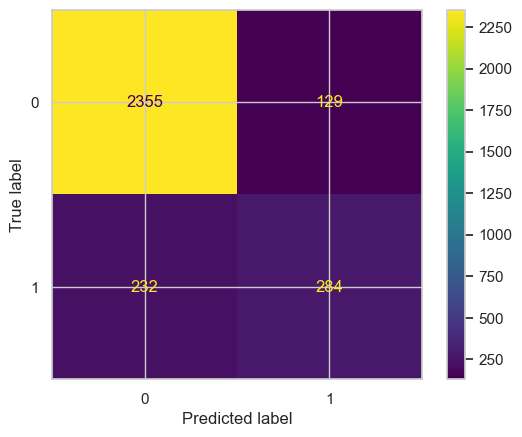

In [52]:
print("Accuracy BALANCED:", round(metrics.accuracy_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Precision BALANCED:", round(metrics.precision_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("Recall BALANCED:", round(metrics.recall_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))
print("F1 BALANCED:", round(metrics.f1_score(y_true = preds_rf_balanced, y_pred = y_test.ravel()), 2))

plot_confusion_matrix(estimator=rf_balanced, X = X_test, y_true = y_test, values_format='.0f')

In [ ]:
# Hemos mejorado un 16% la precision y un 8% el F1 Score 
# sólo cambiando un parámetro en la creación del modelo.

# Que el modelo sea capaz de detectar dichos casos de abandono no nos asegura 
# que vayamos a reducir la tasa en la que los clientes nos abandonan, 
# pero nos da herramientas para avanzarnos a ello 
# y tomar medidas que sí pueden ayudar a fidelizar a nuestros clientes.